In [837]:
using LinearAlgebra
using SparseArrays
using Plots

In [838]:
struct Rectangle
    center
    halflength::Float64
    halfheight::Float64
end

In [839]:
function onezero(Tx,Ty,shape)
    grid = Tx .* zeros(length(Ty))
    
    for j = 1:size(grid,1)
        for i = 1:size(grid,2)
            grid[j,i] = (abs(Tx[i]-shape.center[1]) <= shape.halflength ) && (abs(Ty[j]-shape.center[2]) <= shape.halfheight ) ? 1 : 0
        end
    end
    
    return grid
end

onezero (generic function with 1 method)

In [840]:
nx = 280
ny = 144;

## construct operators

In [886]:
ρ = 2700;
c = 8.97e02;
k = 1.67e02;
d = 2e-3;

In [975]:
Γ = k/(c*ρ);
dt = 1e-3;

inch = 2.54e-2
Lx = 0.1270;
Ly = 0.0648;
dx = Lx/nx
dy = Ly/ny



xfactor = Γ*dt/2/dx^2
yfactor = Γ*dt/2/dy^2;

In [976]:
N = nx*ny
dlx = ones(N-1)
dx  = -2ones(N)
drx = deepcopy(dlx);

dx[1:nx:end] .= -1.0
dx[nx:nx:end] .= -1.0
dlx[nx:nx:end] .= 0.0
drx = dlx;

In [977]:
dly = ones(N-1)
dy  = -2ones(N)
dry = deepcopy(dly);

dy[1:ny:end] .= -1.0
dy[ny:ny:end] .= -1.0
dly[ny:ny:end] .= 0.0
dry = dly;

In [978]:
Fourier = Γ*dt/(Lx/nx)^2

0.3351728905035084

## initial values

In [979]:
Tx = range(0+0.5Lx/nx,Lx-0.5Lx/nx,length=nx)'  # note ': this is a row vector
Ty = range(0+0.5Ly/ny,Ly-0.5Ly/ny,length=ny)


# Tvalue =  @. 0 * cos(pi*Tx/Lx) +  0* cos(pi*Ty/Ly);


σ = 0.01 # width of pulse
A = 10.0 * 0 # strength (easy to set to 0 if you don't want to do this problem)
Tvalue =  @. A*exp(-((Tx-Lx/2)^2+(Ty-Ly/2)^2)/σ^2);

In [980]:
Tvecy = vcat(Tvalue...);
Tvecx = vcat(transpose(Tvalue)...);

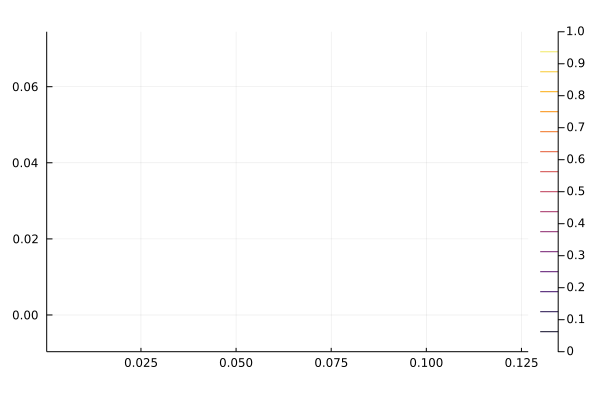

In [981]:
contour(Tx',Ty,Tvalue,aspectratio=1)

In [982]:
DDx = xfactor*Tridiagonal(dlx,dx,drx)
DDy = yfactor*Tridiagonal(dly,dy,dry)

@time DDTx = DDx*Tvecx
@time DDTy = DDy*Tvecy


T2Dx = reshape(DDTx,nx,ny)'
T2Dy = reshape(DDTy,ny,nx);

  0.000216 seconds (2 allocations: 315.078 KiB)
  0.000210 seconds (2 allocations: 315.078 KiB)


## operator convergence check

In [983]:
T2Dxref = Tvalue =  @. -pi*pi* cos(pi*Tx) + 0* cos(pi*Ty);
T2Dyref = Tvalue =  @. 0* cos(pi*Tx) + -pi*pi* cos(pi*Ty);

In [984]:
norm(T2Dxref-T2Dx,2)/sqrt(nx*ny)
norm(T2Dyref-T2Dy,2)/sqrt(nx*ny)

9.801764079890924

In [985]:
# x dir
Tlabel = 1:length(Tvalue[:])
Tvcatx = reshape(Tlabel,ny,nx)'
Tvcatx
transpose(Tvcatx)[:]

# y dir
Tvcaty = reshape(Tlabel,nx,ny)
Tvcaty
Tvcaty[:];


## Add a rectangular heater with constant power

In [986]:
fact = 1.0/(c*ρ*d)

0.00020644948181180065

In [987]:
shape1 = Rectangle((0.5Lx-0.7inch,0.5Ly),0.5inch,0.45Ly)
shape2 = Rectangle((0.5Lx+0.7inch,0.5Ly),0.5inch,0.45Ly)
shapeheater = [shape1;shape2]
qe = 15500.0
heatflux = fact * qe

3.19996696808291

In [988]:
heatergrid = sum(onezero.([Tx],[Ty],shapeheater))
qheatervec = heatflux .* heatergrid[:];

In [989]:
maximum(qheatervec)

3.19996696808291

## Add a rectangular condenser with constant temprature

In [990]:
shape3 = Rectangle((0.5Lx - 2.5inch,0.5Ly),0.25inch,0.45Ly)
shape4 = Rectangle((0.5Lx + 2.5inch,0.5Ly),0.25inch,0.45Ly)


shapecond =  [shape3;shape4]

hc = 2000.0
Tc = 0.0

hfact = fact * hc

0.4128989636236013

In [991]:
condensergrid = sum(onezero.([Tx],[Ty],shapecond))
condenservec =  condensergrid[:];

## derive results

In [992]:
num = 1000
ΔN = 10

Thist = []
Tlast = deepcopy(Tvecy)

push!(Thist,Tvecy)

@time for i = 1:num
    
 
    Told = deepcopy(Tlast)
    

        T2Dold = reshape((I + DDy)*Told,ny,nx)
        Tvecold = transpose(T2Dold)[:]
        Ttemp = (I - DDx)\Tvecold
    
    
        qcondvec = hfact .* (Tc .- Told) .* condenservec
    
    

        T2Dtemp= reshape((I + DDx)*Ttemp,nx,ny)
        Tvectemp = transpose(T2Dtemp)[:];
#         Tnew  = (I - DDy)\Tvectemp
        Tnew  = (I - DDy)\Tvectemp + dt .* (qheatervec + qcondvec)
        
        Tlast = Tnew
    
    if mod(i,ΔN) == 0
        push!(Thist,Tnew)
    end

end

  5.227575 seconds (99.98 k allocations: 11.119 GiB, 4.54% gc time)


In [993]:
T2Dhist = reshape.(Thist,ny,nx);

In [994]:
length(T2Dhist)

101

## plot results

In [995]:
maximum(T2Dhist[end])

2.8171033049953595

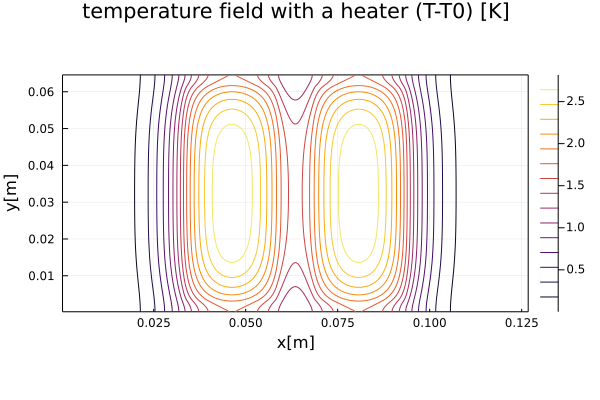

In [1002]:
contour(Tx',Ty,T2Dhist[end],title ="temperature field with a heater (T-T0) [K]",aspectratio=1,xlabel="x[m]",ylabel="y[m]",xlim=(Tx[1],Tx[end]),ylim=(Ty[1],Ty[end]), framestyle = :box)

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\notebooks\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\notebooks\\tmp.gif")
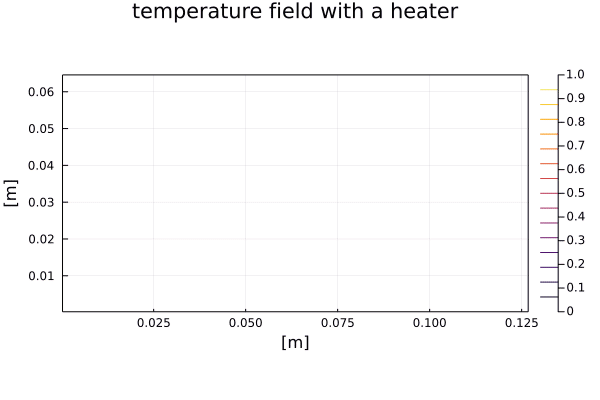

In [1000]:
@gif for i = 1:1:length(T2Dhist)
    
#     contour(Tx',Ty,T2Dhist[i],title =i*dt)
    contour(Tx',Ty,T2Dhist[i],title ="temperature field with a heater",aspectratio=1,xlabel="x[m]",ylabel="y[m]",xlim=(Tx[1],Tx[end]),ylim=(Ty[1],Ty[end]), framestyle = :box)
    
end

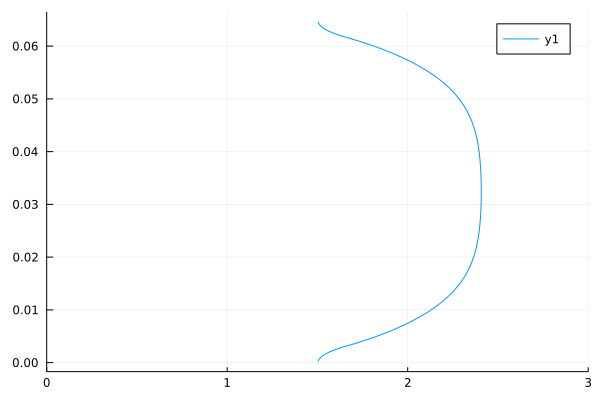

In [1009]:
plot(T2Dhist[end][:,160],Ty,xlim=(0.0,3.0))

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\notebooks\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\notebooks\\tmp.gif")
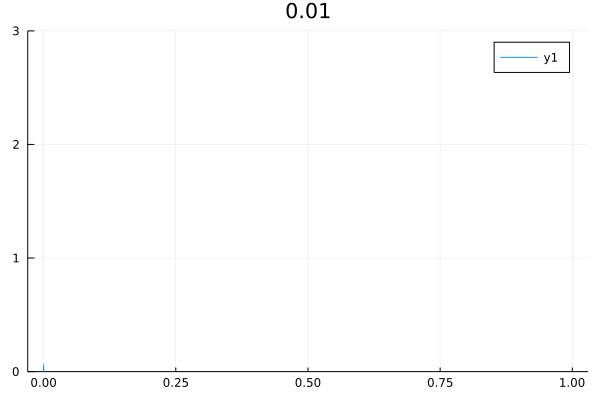

In [1003]:
@gif for i = 1:1:length(T2Dhist)
    
    plot(T2Dhist[i][:,120],Ty,title =i*ΔN*dt,xlim=(0.0,3.0))
    
end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\notebooks\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\notebooks\\tmp.gif")
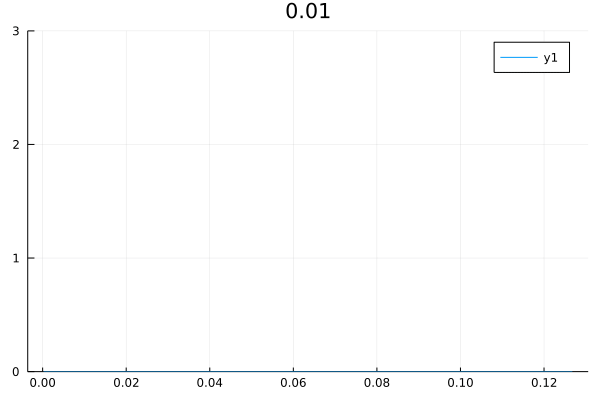

In [998]:
@gif for i = 1:1:length(T2Dhist)
    
    plot(Tx',T2Dhist[i][10,:],title =i*ΔN*dt,ylim=(0.0,3.0))
    
end


In [864]:
b = rand(10)
A = rand(10,10)


10×10 Array{Float64,2}:
 0.37827    0.990523  0.978416   0.834854   …  0.391552  0.034251  0.241781
 0.389114   0.595793  0.913402   0.199606      0.902925  0.129292  0.624746
 0.423852   0.390597  0.620819   0.947553      0.612053  0.338477  0.236069
 0.526843   0.199465  0.983784   0.679571      0.822068  0.264952  0.140408
 0.53744    0.283099  0.0402867  0.247935      0.540028  0.635879  0.351925
 0.403559   0.931704  0.846667   0.206354   …  0.553461  0.569728  0.61776
 0.461665   0.318968  0.959657   0.0466379     0.910682  0.668332  0.201218
 0.0595139  0.578017  0.994043   0.888187      0.418069  0.779893  0.280356
 0.885588   0.731554  0.862839   0.874281      0.485911  0.775565  0.439182
 0.140676   0.517282  0.528445   0.998456      0.280967  0.475016  0.790743

In [865]:
# @gif for i=1:length(T2Dhist)
    
#     plot(T2Dhist[i][1,:])
    
# end

In [866]:
T2Dy

144×280 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [867]:
T2Dx

144×280 Adjoint{Float64,Array{Float64,2}}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  

In [868]:
fourier = 

LoadError: [91msyntax: incomplete: premature end of input[39m

In [869]:
T

LoadError: [91mUndefVarError: T not defined[39m